In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from IPython.display import Markdown, display
from matplotlib.patches import Rectangle

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)

def printmd(string):
    display(Markdown(string))

data = pd.read_csv('/kaggle/input/kaggle-survey-2020/kaggle_survey_2020_responses.csv')
headers = data.loc[:1]
data= data.drop(index=0,axis=0)
data['Time from Start to Finish (seconds)'] = pd.to_numeric(data['Time from Start to Finish (seconds)'])


In [ ]:
'''This gets a list of columns that follow the assumed/observed 
naming convention of the dataset based on a simple input Q<number>. 
i.e. Q7 can be provided and the columns and labels for all Q7 columns will be returned. '''
def extractCols(question):
    pattern = re.compile("^" + question + "(_|$)")
    neededCols = []
    xLabels = []
    for col in headers.columns:
        if pattern.match(col):
            neededCols.append(col)
            choice = headers[col][0].split('Selected Choice - ')[-1]
            trimmedChoice = choice.split('(')[0]
            xLabels.append(trimmedChoice)
    #watch out for questions with A and B parts
    foundAPart = False
    foundBPart = False
    for col in neededCols:
        if "_A_" in col:
            foundAPart = True
        if "_B_" in col:
            foundBPart = True
    if foundAPart and foundBPart:
        raise Exception("Question has an A and B part. Specify the needed part.")

    return neededCols,xLabels

In [ ]:
'''Plot a bar chart with one or more series
   All must use the same X labels

'''
def sideBySidePlot(x1,ys,title,y2s=[]):
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    center = 0
    width = 0.8/len(ys)
    ind = np.arange(len(x1))
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    fig.suptitle(title)
    
    for y in range(len(ys)):
        ax1.bar(ind + (((y+0.5) *width) - (len(ys)/2) * width), ys[y],width,color=colors[y])
        ax1.set_ylabel('Total')
    
    if len(y2s) > 0:
        ax2 = ax1.twinx()
        for y in range(len(y2s)):
            ax2.scatter(ind + (((y+0.5) *width) - (len(ys)/2) * width), y2s[y],width,color=colors[y])
            ax2.set_ylabel('Percent %')
            miny, maxy = ax2.get_ylim()
            ax2.set_ylim(0, maxy)
    
    
    ax1.set(xticks=ind + center, xticklabels=x1)#, xlim=[2*width - 1, len(x1)])
    ax1.set_xticklabels(labels=x1, rotation = 45, ha="right")

In [ ]:
'''
    Create a plot based on a single column with many different categorical values
    or many columns with a single unique value in each. 
'''
def comparePlot(question,df,usePercent):
    #get the columns from the clean dataset
    neededCols,xLabels = extractCols(question)
    groupItem = df[neededCols]
    #get the assumed header for the graph based on the question
    title = headers[neededCols[0]][0].split('?')[0] + '?'
    title = title.split(":")[0] + ":"
    ys = []
    y2s = []
    if(len(neededCols) == 1): # single col
        
        graphDf = pd.DataFrame(index=df[neededCols[0]].value_counts().index)
        
        graphDf[groupItem[neededCols[0]].iloc[0]] = groupItem[neededCols[0]].value_counts()
        graphDf =graphDf.fillna(0)
        yn = graphDf[groupItem[neededCols[0]].iloc[0]].values
        ys.append(yn)
        if usePercent:
           y2s.append((100 * yn / len(df)))
        x1 = graphDf.index.values
           
        sideBySidePlot(x1,ys,title,y2s) #graph it
    else:  #multi col
        graphSet = []
        desc = groupItem.loc[:,neededCols].describe()
        #make sure data is 1 unique per col
        if (desc.loc['unique'] > 1).sum() > 0:
            raise Exception("A multi column graph was needed but one or more columns have more than one unique value." + 
                    "Columns with multiple values must be graphed individually")
        graphSet.append(desc)

        graphDf = pd.DataFrame(index=xLabels)
        
        x1 = xLabels
        for lot in graphSet:
            yn = lot.loc['count'].values
            ys.append(yn)
            if usePercent:
                y2s.append((100 * yn / len(df)))
                 

        sideBySidePlot(x1,ys,title,y2s) #graph it

#Top 10 machine learning toolkits to make you an attractive hire
When you're attempting to transition into a machine learning or data science field, the array of tools on offer can be overwhelming. What platforms should you familiarise yourself with? Which algorithms should you learn to use? Do you need a broad range of experience to get a job? Or should you attempt to specialise?  
So many questions. So little concrete information.  
Until now.  
This study provides data-driven recommedations as to the toolkits that will be most useful when you're applying for jobs or even a promotion. Read on to learn how you can start building a robust skill set that'll make you attractive to recruitment teams, without you having to learn to use every platform and algorithm under the sun.

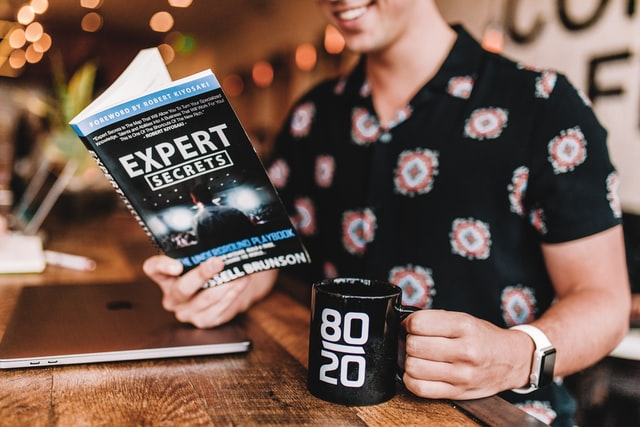
<span>Photo by <a href="https://unsplash.com/@austindistel?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Austin Distel</a> on <a href="https://unsplash.com/s/photos/expert?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

In [ ]:
#only pick rows with a response to Q5
q5Cols = extractCols('Q5')[0]
data.dropna(how='all',subset=q5Cols,inplace=True)
# no students
data = data[data['Q5'] != 'Student']
#only people with 2+ years working with ML from question 15
experienceCols = ['2-3 years','3-4 years','4-5 years','5-10 years','10-20 years','20 or more years']
data = data[data['Q15'].isin(experienceCols)]


# get the column names for Q17
q17Info = extractCols('Q17')
q17Cols = q17Info[0]
q17Labels = q17Info[1]
#part 11 was the None response so exclude that
q17Cols.remove('Q17_Part_11')
q17Labels.remove('None')
#anything that contains something other than nan in these columns counts as one response
q17Data = data.dropna(how='all',subset=q17Cols)
#print(len(q17Data))

#get the Q18 cols
q18Info = extractCols('Q18')
q18Cols = q18Info[0]
q18Labels = q18Info[1]
q18Cols.remove('Q18_Part_6')
q18Labels.remove('None')
q18Data = data.dropna(how='all',subset=q18Cols)
#print(len(q18Data))

#get the Q19 cols
q19Info = extractCols('Q19')
q19Cols = q19Info[0]
q19Labels = q19Info[1]
q19Cols.remove('Q19_Part_5')
q19Labels.remove('None')
q19Data = data.dropna(how='all',subset=q19Cols)
#print(len(q19Data))

#get the Q16 cols
q16Info = extractCols('Q16')
q16Cols = q16Info[0]
q16Labels = q16Info[1]
q16Data = data.dropna(how='all',subset=q16Cols)
#print(len(q16Data))

#Q12 data
q12Info = extractCols('Q12')
q12Cols = q12Info[0]
q12Labels = q12Info[1]

##The roles of professionals in the field
Because you're interested in learning about the toolkits professionals use, for this article, we had to choose a subset of the data that reflects the practices of professionals. So, we eliminated the responses of those respondents who identified as students (Q5 in the survey). We also decided the most useful advice would be born out of responses from professionals with at least two years of experience using machine learning methods (Q15). After all, those who're still learning the ropes of their role may not be using the best tools for their work.  
We also removed the data associated with respondents who said they don't use any machine learning algorithms on a regular basis since that information doesn't help you develop a robust machine learning toolkit (Q17).  
Having done that, the first information we looked at was job roles.  
The vast majority of survey respondents were data scientists. As a result, the raw data is skewed towards algorithms and tools useful for data scientists. 

In [ ]:
comparePlot('Q5',q17Data,True)

Normally, such a skew might make analysing the data more difficult. However, since the skills used by data scientists are fundamental to most machine learning roles, we concluded that the large number of responses from data scientists shouldn't negatively impact on the conclusions we might draw about the toolkits used by professionals across the board.
Given there were also plenty of responses from professionals working in a variety of distinct fields (with the exception of DBA/database engineer roles), we believed there would be sufficient data with which to attempt to draw conclusions about the toolkits of professionals working in specific fields as well.  
Having drawn that conclusion, we then analysed the machine learning algorithms used by our subset of survey respondents.

##The most commonly used machine learning algorithms
Almost every machine learning student starts by learning to use linear or logistic regression algorithms. And if you’re like many trying to break into machine learning as a profession, you might wonder whether it’s really useful to learn to use such algorithms in the long term, assuming, perhaps, that more experienced professionals quickly move on to more advanced or specialised algorithms.  
If so, you’ll be surprised to learn that Kaggle’s 2020 Machine Learning and Data Science Survey indicates that professionals continue to use linear or logistic regression on a regular basis. In fact, 79% of the professionals surveyed use regression-based algorithms regularly.

In [ ]:
comparePlot('Q17',q17Data,True)

So, don’t slack off when studying that material. You’ll be using it for years to come.
Other commonly used algorithms into which you might choose to invest time and effort include decision trees or random forests (71% of professionals regularly use those), gradient boosting machines, Bayesian approaches, dense neural networks, convolutional neural networks and recurrent neural networks. But don’t get started learning to use these just yet as this data doesn’t paint the full picture.  
If you read on, you'll find more specific (and timesaving) recommendations to boost your employment potential.

In [ ]:
'''
This function iterates over a subset of columns to count every instance where 
any subject pair of columns are both selected ( i.e. neither is NaN or None). 
It turns this data into a DataFrame where both the index and columns have the provided labels 
and the count for that pair in the cell. 
i.e If A and B are both selected by a respondent we count that as 1.
If A is selected and B is not that is 0
If neither A or B are selected that is 0
'''
def combinationMap(df,cols,labels):
    if(len(cols) != len(labels)):
        raise Exception("Length of cols and labels must be the same.")
    #create the heatmap dataframe
    combDf = pd.DataFrame(columns=labels,index=labels)
    for col in range(len(cols)): # for every column
        for myIndex in range(len(cols)): #compare with every other column and itself
            #the next line is a lot of pandas code that:
            #selects that pair of columns
            #sets the NaN/None vaules to True
            #sum each row (True =1 False =0)
            #select the subset of rows that are 0 i.e. Neither were None
            #count the number of rows that remain
            #set that count as the value for the corrisponding cell in the new table
            combDf.at[labels[myIndex],labels[col]] = len(df[df[[cols[col],cols[myIndex]]].isna().sum(axis=1) == 0])
    # the result is a frame with counts of each time that pair is selected
    return combDf

In [ ]:
'''Setup a seaborn heatmap'''
def showHeatMap(df,format=None,title=None,dims=(10,10),ax=None,xticks=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=dims)
    if format:
        heatmap = sns.heatmap(ax=ax, data=df,annot=True, fmt=format,xticklabels=xticks)
    else:
        heatmap = sns.heatmap(ax=ax, data=df,xticklabels=xticks)
    heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=45,ha="right")
    if title:
        heatmap.set_title(title)
    for i in range(len(df)):
        ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=4))
        ax.add_patch(Rectangle((0, i), len(df.iloc[0]), 1, fill=False, edgecolor='white', lw=1))
        
    return heatmap

In [ ]:
#get the Q17 pair-wise counts as both raw values and as percentage
alsoDf = combinationMap(q17Data,q17Cols,q17Labels)
percentDf = alsoDf/len(q17Data)

In [ ]:
''' Create a heatmap with the raw values and percentages displayed on each cell'''
def sideBySideHeatMap(df,totalNum,superTitle):
    fig, ax = plt.subplots(1,1,figsize=(12,10))
    fig.suptitle(superTitle)
    fig.subplots_adjust(hspace=0.01)
    showHeatMap(df.astype(int),"d",ax=ax)

    percentDf = (df/totalNum)*100
    reannotatePercent(percentDf,ax)

    return ax
''' Add additional text to all cells in a heatmap'''
def reannotatePercent(df,ax):
    cellCol = 0
    cellRow = 0
    if(len(ax.texts) != (len(df.columns) * len(df))):
        raise Exception("The provided dataframe is not the right size for the axis texts. Wrong input?")
    for i in range(len(ax.texts)):
        cellRow = int(i/len(df.columns))
        cellCol = int(i % len(df.columns))
        ax.texts[i].set_text(ax.texts[i].get_text() + "\n(" + "%2d" % round(df.iloc[cellRow][cellCol]) + "%)")


The numbers of professionals using specific machine learning algorithms clearly demonstrates that the vast majority of professionals use two or more algorithms on a daily basis. For example, 79% of professionals are using regression-based algorithms and 71% are using tree- or forest-based algorithms, so a substantial proportion of the respondents must be regularly using both types of algorithms.  
But which algorithms are most commonly used together?   
Once you know that, you can start to build a picture of the kinds of toolkits that could help you win your dream job. And that's where the next piece of our analysis comes in.   
We calculated the number of respondents who reported using each pair of machine learning algorithms, regardless of whether they also use additional algorithms, and presented them in a heatmap. The diagonal that runs from the top left to the bottom right of each diagram (outlined in white) represents the total number of professionals who reported using each algorithm. This means you can compare the number of professionals using a given algorithm with the numbers of professionals using that algorithm as well as any other algorithm included in the survey. (As you go through the next part of this article, have some fun studying each row of the heatmaps separately to see which combinations are popular and which are rare. These kinds of comparisons form the basis of the rest of this article.)   

###Common pairs of machine learning algorithms
As you might guess, well over half of the professionals surveyed (63%) use linear or logistic regression along with decision trees or random forests. Many of them also include gradient boosting machines and/or convolutional neural networks in their toolkits. In fact, the most common set of tools across the professionals surveyed were linear or logistic regression, decision trees or random forests and gradient boosting machines. This may reflect a problem solving framework that many professionals follow.  
For example, it’s probably very common for professionals to start out with a basic regression and then move onto a tree-based method if the regression didn’t work or they need further information. Gradient boosting machines then become useful when ‘weak learners’ are identified with the tree-based method.

In [ ]:
#heatmap of common pairs in the Q17 data
ax = sideBySideHeatMap(alsoDf,len(q17Data),superTitle="ML Algorithm combinations regularly used by experienced professionals")
#help people to read the data with a few annotations
ax.annotate('3235 (79%) total\nRegression users',
            xy=(0.5, 0.3), xycoords='data',
            xytext=(0, 1.07), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',fontsize=12, color='tab:blue')

ax.annotate('1897 (46%) are using Regressions and Gradient Boosting',
            xy=(2.5, 0.3), xycoords='data',
            xytext=(1, 1.07), textcoords='axes fraction',
            arrowprops=dict(facecolor='blue', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',fontsize=12, color='tab:blue');


In [ ]:
#calculate some stats for the text
evoTotal = alsoDf.loc['Evolutionary Approaches']['Evolutionary Approaches']
evoTotalPerc = round(percentDf.loc['Evolutionary Approaches']['Evolutionary Approaches'] * 100)
evoAndLin = alsoDf.loc['Evolutionary Approaches']['Linear or Logistic Regression']
evoAndLinPerc = round(percentDf.loc['Evolutionary Approaches']['Linear or Logistic Regression'] * 100)
evoRelPerc = round(alsoDf.loc['Evolutionary Approaches']['Linear or Logistic Regression']/alsoDf.loc['Evolutionary Approaches']['Evolutionary Approaches'] * 100)
genRelPerc = round(alsoDf.loc['Generative Adversarial Networks']['Linear or Logistic Regression']/alsoDf.loc['Generative Adversarial Networks']['Generative Adversarial Networks'] * 100)
transformerRelPerc = round(alsoDf.loc['Transformer Networks ']['Linear or Logistic Regression']/alsoDf.loc['Transformer Networks ']['Transformer Networks '] * 100)

printmd("Interestingly, convolutional neural networks seem to be used in concert with a wider range of other algorithms. Convolutional is certainly the most prevalent neural network, however, professionals seems to be working with several algorithms by the time they need to move into neural networks. Relatively few of the professionals surveyed use evolutionary approaches, generative adversarial networks or transformer networks on a regular basis. But of those that do, the vast majority (%2d%%, %2d%% and %2d%% respectively) also use some form of regression as well. Clearly, professionals recognise the benefits of keeping things simple wherever possible." %(evoRelPerc,genRelPerc,transformerRelPerc))
printmd("If you're confused about how those large percentages come from the above heatmap, keep in mind it's all relative. For instance, only %d (%2d%%) of professional survey respondents use evolutionary methods, while %d (%2d%%) of all professional survey respondents use both evolutionary and regression methods. That gives you: %d/%d*100 = %2d%%. So therefore 79%% of those using evolutionary approaches are also using regression methods." %(evoTotal,evoTotalPerc,evoAndLin,evoAndLinPerc,evoAndLin,evoTotal,round(evoAndLin/evoTotal*100)) )


To take this analysis a step further, here are the top five machine learning algorithm toolsets used by professionals across the board.

In [ ]:
''' Use pandas to group all rows with the exact same selections across the columns
    then print the top N combinations for the notebook
'''
def showTopXCombos(df,cols,topN):
    #group identical selections across the subset of columns
    combinations = df.astype(str).groupby(by=cols).size().reset_index()
    #calculate the percentage of rows with each selection
    combinations["Percentage"] = combinations[0]/len(df) * 100
    #sort with most frequent at the top
    combinations = combinations.sort_values("Percentage", ascending=False)
    combinations.reset_index()
    prettyStr = ""
    #print the top N values from the table
    for i in range(topN):
        prettyStr = str(i+1) + ": "
        first = True
        for col in cols:
            if(combinations.iloc[i][col] != 'nan'):
                if first != True:
                    prettyStr += " - "
                prettyStr += "" + combinations.iloc[i][col].split(" (")[0]
                first = False
                
        
        printmd(prettyStr + " (" + str(combinations.iloc[i][0]) + " identical responses)")
#show the most common selections in Q17
showTopXCombos(q17Data,q17Cols,5)

Notice that number five in the list is just regression-based algorithms. Later in the article you'll find out why that's the case.  
Now, having discovered the most commonly used machine learning algorithms, it's also useful to know which frameworks professionals are employing when using said algorithms, as limiting the number of frameworks you have to learn is another way to save time and effort.  
To investigate this, we constructed another heatmap.

##Commonly used frameworks
Given the heavy reliance on regression and tree-based algorithms, it comes as no surprise that scikit-learn is the most commonly used framework among professionals, with 77% of those surveyed using it on a regular basis.

In [ ]:
#which frameworks do our experts use
frameworkDf = combinationMap(q17Data,q16Cols,q16Labels)
ax = sideBySideHeatMap(frameworkDf,len(q17Data),superTitle="Framework combinations regularly used by experienced professionals")

TensorFlow, Keras and PyTorch are also frequently used together, in isolation and with scikit-learn. Interestingly, the newer PyTorch is the least popular of this set, perhaps because professionals haven’t needed to adopt a competitor to TensorFlow — or because PyTorch’s marketing has been less persuasive.  
Given the high prevalence of surveyed professionals who use gradient boosting algorithms, the relatively high incidence of Xgboost users is also logical. However, it is interesting to note that Xgboost dominates over LightGBM and CatBoost. If you're planning on adding one or more gradient boosting algorithms to your toolset, it appears you may be better off learning to use Xgboost as opposed to one of the alternative frameworks.

So far in this article, you've gained some insight into the primary tools used by professionals across the board for general machine learning and data science tasks. But you may be wondering whether specific problem sets affect the algorithms used by the average professional.  
To answer this question, we reviewed the responses of those professionals that use computer vision (Q18) and natural language processing (Q19) tools and produced another set of heatmaps.   
It's important to note that we have assumed those subsets of survey respondents are computer vision and natural language processing experts or specialists. That's a bit of a long bow to draw, however, there is a noticeable and logical difference between the heatmaps produced for each set of professionals. So, in the absence of a survey question that enables us to draw out the responses of true computer vision and natural language processing specialists, we believe the following analysis at least provides a basis upon which you can research the ideal toolkits for each specialty. If you're interested in specialising in computer vision or natural language processing, we hope you'll find the next couple of sections interesting and enlightening.

# Commonly used visual data processing methods
Image classification and other general purpose networks were the visual data processing tools of choice for the professionals who responded to the 2020 Machine Learning and Data Science Survey. While 78% of professionals in total use such methods, roughly 40% use those tools in concert with general purpose image/video tools, image segmentation methods or other detection methods.

In [ ]:
#Look at the selections on the Computer Vision question
vizDf = combinationMap(q18Data,q18Cols,q18Labels)
sideBySideHeatMap(vizDf,len(q18Data),superTitle="Computer Vision Methods regularly used by experienced professionals");


Interestingly, there is a big difference in the types of machine learning algorithms used by the professionals who answer the question about visual data processing tools as compared to the broader pool of professional respondents. Below you'll find the top five combinations of machine learning algorithms used by professionals engaged in computer vision work. If you're interested in pursuing a career that includes computer vision techniques, it seems you might be well served by learning to use convolutional neural networks as well as the other algorithms previously highlighted. If you have some spare time up your sleeve, you might improve your resume if you can add dense neural networks and recurrent neural networks.

In [ ]:
#top selections for Q17 by people who answered Q18
showTopXCombos(q18Data,q17Cols,5);

Despite the difference in algorithm toolsets, the combinations of frameworks used by computer vision professionals was very similar to those used by the whole pool of professionals that responded to the survey.

In [ ]:
#CV framework selections
frameworkDf = combinationMap(q18Data,q16Cols,q16Labels)
ax = sideBySideHeatMap(frameworkDf,len(q18Data),superTitle="Framework combinations regularly used by Computer Vision professionals")

##Commonly used natural language processing methods
Word embeddings/vectors are the most popular methods of conducting natural language processing with 80% of the professionals surveyed reporting that they use them on a regular basis. Nearly half of the professionals surveyed used word embeddings/vectors with encoder-decoder models or transformer language models.

In [ ]:
#NLP Alg selections
nlpDf = combinationMap(q19Data,q19Cols,q19Labels)
sideBySideHeatMap(nlpDf,len(q19Data),superTitle="NLP Methods regularly used by experienced professionals");


The machine learning algorithm toolkits used by professionals engaged in natural language processing activities were once again decidedly different from machine learning and data science professionals as a whole — and from computer vision professionals as well. As you can see from the below list of the top five combinations of machine learning algorithms, professionals performing natural language processing were far more likely to use neural networks on a regular basis. 
In fact, these professionals appear to use the broadest range of algorithms so far, including some of the rarer ones. So, if you're interested in a career that involves natural language processing, you may have a lot of study ahead of you! 

In [ ]:
#top seletions for Q17 by people who answered Q19
showTopXCombos(q19Data,q17Cols,5)

Once again, the key frameworks most commonly used by this subset of respondents remained fairly consistent with the sets of frameworks used by computer vision professionals and the professional survey respondents as a whole.

In [ ]:
#NLP frameworks
frameworkDf = combinationMap(q19Data,q16Cols,q16Labels)
ax = sideBySideHeatMap(frameworkDf,len(q19Data),superTitle="Framework combinations regularly used by NLP professionals")

##Toolkits used by different professions
The analysis thus far has focussed on the tools used by professionals as a whole. And while you could go away and spend hundreds of thousands of hours learning the intricacies of all the most popular algorithms, frameworks, computer vision methods and natural language processing methods, you could save a huge amount of time and effort if you focus your studies on the toolkit that’s most commonly employed in a specific professional role. Not only that, but recruitment officers may see your experience and interests as more relevant if they’re narrowly focussed on the tools that are most useful in the job you’re applying for.  
So, to help you with that, we analysed the tools used by survey respondents that identified as working in each specific role. And the first thing we want to draw your attention to is the stark difference between the various professions. In particular, the professions on the left of the below figure use much more narrowly focussed toolsets than those professions on the right.   
If you're not yet sure which specialisation you'd like to aim for, you might like to choose one of those listed on the left as you would be able to develop a more ideal skill set with a relatively reduced amount of study.
Once you've perused that high level overview of the various professions, keep reading as we provide further details and draw out a set of the top 10 machine learning toolkits.

In [ ]:
'''
 Make a smaller heatmap for visual comparison
'''
def showMiniHeatMap(df,format=None,title=None,dims=(10,10),ax=None,cbar=False,xticks=True,yticks=True,vmin=0, vmax=0.92):
    if ax is None:
        fig, ax = plt.subplots(figsize=dims)
    if format:
        heatmap = sns.heatmap(ax=ax, data=df,annot=False, fmt=format,cbar=cbar,xticklabels=xticks,yticklabels=yticks,vmin=vmin, vmax=vmax)
    else:
        heatmap = sns.heatmap(ax=ax, data=df,cbar=cbar,xticklabels=xticks,yticklabels=yticks,vmin=vmin, vmax=vmax)
    heatmap.set_xticklabels(heatmap.get_xticklabels(),rotation=45,ha="right")
    if title:
        heatmap.set_title(title)
    for i in range(len(df)):
        ax.add_patch(Rectangle((i, i), 1, 1, fill=False, edgecolor='white', lw=0.4))
        ax.add_patch(Rectangle((0, i), len(df.iloc[0]), 1, fill=False, edgecolor='white', lw=0.1))

'''
 Supply a job title and get a Q17 heatmap for that job title
'''        
def jobTitleHeatMap(jobTitle,nAx,xticks,yticks):
    jobData = q17Data[q17Data['Q5']== jobTitle]
    jobDf = combinationMap(jobData,q17Cols,q17Labels)/len(jobData)
    showMiniHeatMap(jobDf.astype(float),format="0.2f",title=jobTitle,dims=(5,5),ax=nAx,cbar=False,xticks=xticks,yticks=yticks)

# create a set of small heatmaps for visual comparison
orderedJobs = ['Statistician','Data Scientist','Data Analyst', 'Machine Learning Engineer','Business Analyst','Software Engineer','Product/Project Manager','Research Scientist','DBA/Database Engineer','Data Engineer','Other','Currently not employed']
nCols = 2
nRows = int(len(orderedJobs)/nCols)
if (len(orderedJobs) % nCols) != 0:
     nRows += 1
fig, ax = plt.subplots(nRows,nCols,figsize=(15,15))
fig.subplots_adjust(wspace=0.01)
rowTracker = 0
colTracker = 0
for indx in range(len(orderedJobs)):
    rowTracker = int(indx/nCols)
    colTracker = int(indx % nCols)
    jobTitleHeatMap(orderedJobs[indx],ax[rowTracker][colTracker],xticks=(rowTracker==nRows-1),yticks=(colTracker==0))




        

###1. The top toolkit used by statisticians
According to the results of Kaggle's 2020 Machine Learning and Data Science survey, the most commonly used toolkit for professional statisticians comprises linear or logistic regression, and decision trees or random forests, with or without Bayesian approaches. However, there weren't a huge number of respondents in this data subset, so you'll have to take this analysis with a grain of salt. Having said that, if your ideal employment is as a statistician, it's probably safe to say that you'll have a better chance of landing your ideal job if you have a good grasp of basic regression- and tree-based algorithms.

In [ ]:
''' 
  Create a detailed heatmap for a supplied job role
'''
def roleGraph(role):
    roleData = q17Data[q17Data['Q5']==role]
    headingStr = "**Top machine-learning-algorithm toolkits for " + role
    if role.endswith("ed"):
        headingStr += "**"
    else:
        headingStr += "s**"
    printmd(headingStr)
    roleMap = combinationMap(roleData,q17Cols,q17Labels)
    ax = sideBySideHeatMap(roleMap,len(roleData),superTitle=role)
    showTopXCombos(roleData,q17Cols,2)
role = 'Statistician'
roleGraph(role)

###2. The top toolkit used by data scientists
The survey results revealed a similar toolkit is commonly used by data scientists. The difference here is that most data scientists use regression-based, tree-based and gradient boosting machine-based machine learning algorithms, and many also use Bayesian approaches on a regular basis. If you’d love to work as a data scientist, you’d be well served by learning to use at least three, but preferably all four, of those algorithms.   
Your resume will look even better if you can add in convolutional neural networks, which are regularly used by nearly half of the data scientists surveyed.

In [ ]:
role = 'Data Scientist'
roleGraph(role)

###3. The top toolkit used by data analysts
The majority of data analysts surveyed use linear or logistic regression, decision trees or random forests, and gradient boosting machines. However, many of them don't bother with gradient boosting machines. So, noting the relatively low number of respondents in this data set, if you want to work in a specialist data analyst role, it's safe to say you'll be well served by learning to use regression- and tree-based machine learning algorithms, and ideally gradient boosting machines as well.

In [ ]:
role = 'Data Analyst'
roleGraph(role)

###4. The top toolkit used by machine learning engineers
The top toolkits used by machine learning engineers are perhaps the most interesting thus far as the majority of professionals in this category either just use convolutional neural networks, or they use a combination of regression-based, tree-based, and gradient boosting machine algorithms along with Bayesian approaches.  
If you're keen to land a job as a machine learning engineer, you might have to do some research into your preferred employers to learn which toolkit is going to stand you in good stead.

In [ ]:
role = 'Machine Learning Engineer'
roleGraph(role)

###5. The top toolkit used by business analysts
Business analysts reported using a limited toolkit comprising linear or logistic regression, decision trees or random forests, and gradient boosting machines. Though many respondents have left off gradient boosting machines. Roughly a third of respondents also added convolutional neural networks to their toolkit, but we would need more data to confidently recommend that be included in your toolkit.

In [ ]:
role = 'Business Analyst'
roleGraph(role)

###6. The top toolkit used by software engineers
Similar to machine learning engineers, the majority of software engineers either use a combination of regression-, tree- and gradient boosting machine-based machine learning algorithms, or they just use convolutional neural networks. So again, if you're keen to land a job as a software engineer, you'll probably have to do some research into your preferred employers to learn which toolkit is going to allow you to deliver the most attractive resume.

In [ ]:
role = 'Software Engineer'
roleGraph(role)

###7. The top toolkit used by product/project managers
Most of the product/project managers surveyed reported using a toolkit heavily reliant on linear and logistic regression, and also comprising decision trees or random forests, and gradient boosting machines, though many don't find they need gradient boosting machines on a regular basis. Almost half of the respondents also reported regularly using convolutional neural networks.

In [ ]:
role = 'Product/Project Manager'
roleGraph(role)

###8. The top toolkit used by machine learning research scientists
Machine learning research scientists reported using a toolkit comprising either regression- and tree-based algorithms or convolutional neural networks. However, dense and recurrent neural networks were also commonly used by those using convolutional neural networks, and gradient boosting was commonly used by those with a more basic toolkit.  
This is another area where it would pay to research your ideal employers before deciding on which toolkit to develop.


In [ ]:
role = 'Research Scientist'
roleGraph(role)

###9. The top toolkit used by DBA/database engineers
DBA/database engineers reported using a limited toolkit comprising linear or logistic regression, and decision trees or random forests, with or without gradient boosting machines. However, very few DBA/database engineers responded to the 2020 survey, so we strongly recommend you further investigate the best toolkit for this role before deciding to limit yourself to the most basic machine learning algorithms.

In [ ]:
role = 'DBA/Database Engineer'
roleGraph(role)

###10. The top toolkit used by data engineers
Data engineers reported using toolkits that are heavily reliant on linear or logistic regression, and decision trees or random forests, along with gradient boosting machines, with or without Bayesian approaches. However, more than half of the survey respondents also reported using convolutional neural networks. It seems there is a greater variation in the commonly used tools among data engineers, so this is another profession for which it would pay to do extra research into the preferences of your ideal employers.


In [ ]:
role = 'Data Engineer'
roleGraph(role)

###Currently not employed
Unfortunately, we were unable to elucidate any clear differential between those employed and not employed. This may be because many businesses had to let go of people with appropriate skill sets in 2020, but there's no way to confirm or refute that hypothesis from the data available in the survey.

In [ ]:
role = 'Currently not employed'
roleGraph(role)

##Commonly used processing units
The majority of professionals reported using GPUs for their machine learning work. Many said they don’t use GPUs or TPUs and are presumably using standard CPUs.  
Very few respondents indicated that they use TPUs. Given neural networks were not the most popular machine learning algorithms, it’s unsurprising that processing units designed specifically to be used for neural network machine learning processes were not the most popular processing units among professionals. However, a far greater proportion of respondents use one or more neural network-based machine learning algorithm, so is a little surprising that TPUs were so very unpopular.  
When it came to computer visual and natural language professionals, very few were willing to rely solely on CPUs and were instead largely reliant on GPUs. A slightly larger proportion of these professionals use TPUs on a regularly basis, but the numbers are still not very high.

In [ ]:
#how do those that answered Q17 respond to Q12
frameworkDf = combinationMap(q17Data,q12Cols,q12Labels)/len(q17Data)
showHeatMap(frameworkDf.astype(float),".2f",dims=(5,5),title="All");
#how do those that answered Q18 respond to Q12
frameworkDf = combinationMap(q18Data,q12Cols,q12Labels)/len(q18Data)
showHeatMap(frameworkDf.astype(float),".2f",dims=(5,5),title="Computer Vision");
#how do those that answered Q19 respond to Q12
frameworkDf = combinationMap(q19Data,q12Cols,q12Labels)/len(q19Data)
showHeatMap(frameworkDf.astype(float),".2f",dims=(5,5),title="NLP");


##Building your machine learning toolkit
Based on the results from Kaggle’s 2020 Machine Learning and Data Science Survey, there are 10 distinct machine learning toolkits used by machine learning and data scientist professionals across the world. And as an aspiring professional, you could save yourself a lot of time and effort, and increase your chances of landing your dream job, if you focus your studies on the toolkits most commonly employed by professionals working in the most relevant niche.  
No matter your aspirations, you’ll benefit from learning to use the basic regression-based machine learning algorithms along with decision trees or random forests. And you’ll get the best results if any algorithms you learn in addition to those, are those most commonly used by professionals in your chosen field.  
Regardless of your preferred role, you’ll probably be best served by avoiding evolutionary approaches, generative adversarial networks and transformer networks, and learning to use them on-the-job if they’re necessary for the role you secure. Otherwise you could expend a lot of effort for no gain other than appeasing any intellectual interest you might have in those algorithms.  
Along with key algorithms, you may want to spend some time learning to use a GPU, especially if you’d like to secure a role that relies on computer vision or natural language processing. In most cases, learning to effectively use a TPU is probably best left to on-the-job training as very few professionals use them on a regular basis.  
If your dream role requires computer vision methods, you’ll get the best results if your first port of call is image classification and other general purpose networks. You could then add general purpose image/video tools, image segmentation methods, and object detection methods. Generative networks are unnecessary unless you know your ideal employer requires knowledge of them.  
Regardless of your aspirations, you’ll be well-served if you learn to use the scikit-learn framework and perhaps TensorFlow and Keras. Xgboost and PyTorch could also be useful additions to your toolkit. The other frameworks are used only sporadically, so unless you have a specific interest in using another framework, learning to use them before securing a role would likely be unnecessary at best (or a waste of time at worst).  
Armed with this knowledge, you no longer have to wonder where you should focus your studies. You now have a data-driven basis for choosing a toolkit that will stand you in good stead when you’re applying for jobs. The hardest part my be choosing your ideal role!